# Training Sample Generation for TempCNN approach to classify standing deadwood and cleaned forest areas

## Import necessary libraries

In [250]:
# Check if using the root_project environment
import sys
print(sys.executable)

/Users/christinakrause/anaconda3/envs/root_project/bin/python


In [251]:
import geopandas as gpd
import pandas as pd
import xarray as xr
import numpy as np
from shapely.geometry import Point
from scipy.spatial import cKDTree
import os
import glob
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import rasterio
import seaborn as sns
import random
print("All packages imported successfully!")

All packages imported successfully!


## Generate points with a specified spacing within polygons from a shapefile

In [252]:
# Change working directory
os.chdir('/Users/christinakrause/HIWI_DLR_Forest/')

In [253]:
def generate_points_from_polygons(input_folder, output_path, crs_epsg, spacing):
    
    all_points = []
    point_id = 0  # Initialize unique ID counter

    for filename in os.listdir(input_folder):
        if filename.endswith(".gpkg"):
            filepath = os.path.join(input_folder, filename)
            print(f"Verarbeite Datei: {filepath}")
            
            # Lade Polygone und transformiere CRS
            polygons = gpd.read_file(filepath).to_crs(epsg=crs_epsg)
            polygons = polygons.rename(columns={"id": "polygon_id"})
            if "Flight_Dat" in polygons.columns and "Flight_Date" not in polygons.columns:
                polygons = polygons.rename(columns={"Flight_Dat": "Flight_Date"})


            for poly_idx, row in polygons.iterrows():
                polygon = row.geometry
                bounds = polygon.bounds

                x_coords = np.arange(bounds[0], bounds[2], spacing)
                y_coords = np.arange(bounds[1], bounds[3], spacing)

                for x in x_coords:
                    for y in y_coords:
                        point = Point(x, y)
                        if polygon.contains(point):
                            point_attrs = row.copy()
                            point_attrs.geometry = point
                            point_attrs['point_id'] = point_id
                            all_points.append(point_attrs)
                            point_id += 1

    if all_points:
        all_points_gdf = gpd.GeoDataFrame(all_points, crs=f"EPSG:{crs_epsg}")
        all_points_gdf.to_file(output_path, driver="GPKG")
        print(f"Gemeinsame Punktdatei gespeichert unter: {output_path}")
        return all_points_gdf
    else:
        print("Keine Punkte generiert.")
        return None

In [254]:
# Apply function
geopackage_path = "Data_Collection/polygons"
output_path = "Data_Collection/points/training_points_10m.gpkg"
training_points = generate_points_from_polygons(geopackage_path, output_path, crs_epsg=3035, spacing=10)
value_counts = training_points["class"].value_counts()
print(value_counts)

Verarbeite Datei: Data_Collection/polygons/training_polygons2023.gpkg
Verarbeite Datei: Data_Collection/polygons/training_polygons2019.gpkg
Verarbeite Datei: Data_Collection/polygons/training_polygons2022.gpkg
Gemeinsame Punktdatei gespeichert unter: Data_Collection/points/training_points_10m.gpkg
class
1    5616
3    2920
2     764
Name: count, dtype: int64


## Extract FCC code for training points

In [255]:
def extract_fcc_dates(fcc_path, points_gdf):
    with rasterio.open(fcc_path) as src:
        points = [(geom.x, geom.y) for geom in points_gdf.geometry]
        fcc_values = [val[0] for val in src.sample(points)]  # Extract raster values
    points_gdf['FCC_Value'] = fcc_values
    return points_gdf

In [256]:
# Apply function
fcc_path = 'Datenpaket_Beginn/fcc_15122024_bav.tiff'
training_points = extract_fcc_dates(fcc_path, training_points)
value_counts = training_points["class"].value_counts()
print(value_counts)

class
1    5616
3    2920
2     764
Name: count, dtype: int64


## Convert FCC codes to standard date format

In [263]:
# Function to convert FCC values to dates using a lookup table
def convert_fcc_to_date(points_gdf, codierung_path):
    codierung_df = pd.read_excel(codierung_path)
    codierung_dict = dict(zip(codierung_df['FCC_Code'], codierung_df['Date']))
    points_gdf['FCC_Date'] = points_gdf['FCC_Value'].map(codierung_dict)
    points_gdf.to_file(output_path, driver="GPKG")
    return points_gdf

In [264]:
# Apply function 
fcc_codierung_path = 'Datenpaket_Beginn/Codierung_Schadzeitpunkte.xlsx'
training_points = convert_fcc_to_date(training_points, fcc_codierung_path)

## Extract time series data from Disturbance Index NetCDF for filtered training points

In [267]:
def extract_time_series_from_netcdf(nc_path, points_gdf, output_folder, crs_epsg=3035):
    # Load NetCDF and assign CRS
    ds = xr.open_dataset(nc_path)
    ds = ds.rio.write_crs(f"EPSG:{crs_epsg}")

    # Extract netCDF grid coordinates
    x_coords, y_coords = ds.x.values, ds.y.values
    grid_points = np.array([(x, y) for x in x_coords for y in y_coords])
    tree = cKDTree(grid_points)
    
    # Container for time series from all points
    all_time_series = []
    missing_points = []
    reasons = []

    for idx, point in points_gdf.iterrows():
        point_id = point['point_id']
        try:
            # Get point location and find nearest netCDF pixel
            x, y = point.geometry.x, point.geometry.y
            _, idx_nearest = tree.query([x, y])
            nearest_x, nearest_y = grid_points[idx_nearest]
    
            # Extract time series for nearest pixel
            ts = ds.sel(x=nearest_x, y=nearest_y, method="nearest")
    
            # Convert flight date
            flight_date_raw = point["Flight_Date"]
            flight_date = pd.to_datetime(flight_date_raw, errors="coerce")
            
            if pd.isna(flight_date_raw):
                missing_points.append(point_id)
                reasons.append(f"invalid or missing flight date: {time}")
                continue
            start_date = flight_date - pd.DateOffset(months=7)
            end_date = flight_date + pd.DateOffset(months=6)
    
            # Subset time range
            ts = ts.sel(time=slice(start_date, end_date))
    
            # Convert to DataFrame
            ts_df = ts.to_dataframe().reset_index()
    
            # Calculate the week difference (rounded)
            ts_df['rel_week'] = ((ts_df['time'] - flight_date).dt.days // 7)
            ts_df['time_str'] = ts_df['rel_week'].apply(lambda x: f"di_t{int(x):+}")
            
            # Specify Columns to keep in new dataframe
            ts_df['point_id'] = point_id
            ts_df['class'] = point['class']
            ts_df['polygon_id'] = point['polygon_id']
            ts_df['FCC_Date'] = point['FCC_Date']
            ts_df['Flight_Date'] = point['Flight_Date']
    
            all_time_series.append(ts_df[['point_id', 'class', 'polygon_id', 'FCC_Date', 'Flight_Date', 'time', 'time_str', 'di']])
    
        except Exception as e:
            missing_points.append(point_id)
            reasons.append(f"exception: {e}")
    # Combine all point time series into one DataFrame
    final_df = pd.concat(all_time_series, ignore_index=True)

    # Ensure output directory exists
    os.makedirs(output_folder, exist_ok=True)

    # Save to CSV
    final_df.to_csv(os.path.join(output_folder, "combined_time_series.csv"), index=False)
    
    # Convert to wide format
    wide_df = final_df.pivot_table(
        index=['point_id', 'polygon_id', 'class', 'FCC_Date', 'Flight_Date'],
        columns='time_str',
        values='di'
    ).reset_index()

    # Save wide format
    wide_path = os.path.join(output_folder, "combined_time_series_wide.csv")
    wide_df.to_csv(wide_path, index=False)
    
    # Save diagnostics
    missing_df = pd.DataFrame({"point_id": missing_points, "reason": reasons})
    missing_df.to_csv(os.path.join(output_folder, "missing_points_debug.csv"), index=False)

    print("Time series extraction completed and saved.")
    print(f"Fertig. Verwendet wurden {final_df['point_id'].nunique()} eindeutige Punkte.")
    print(f"{len(missing_points)} Punkte konnten keine Zeitreihe erzeugen.")


In [268]:
# Apply function
nc_path = 'Datenpaket_Beginn/di_diff_biweek_42_35k.nc'
output_folder = 'Data_Collection/DI_points_timeseries'
points_gdf = gpd.read_file("Data_Collection/points/training_points_10m.gpkg")  # Load your points GeoDataFrame
extract_time_series_from_netcdf(nc_path, points_gdf, output_folder)

/var/folders/30/b6vw42ws7bz0ygm94n4kywgc0000gn/T/ipykernel_79787/193103828.py:61: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  final_df = pd.concat(all_time_series, ignore_index=True)


Time series extraction completed and saved.
Fertig. Verwendet wurden 9300 eindeutige Punkte.
0 Punkte konnten keine Zeitreihe erzeugen.


## Check if time series differ depending on class (1 cleared areas, 2 standing deadwood, 3 healthy forest)

In [269]:
# Folder where CSVs are stored
csv_file = "Data_Collection/DI_points_timeseries/combined_time_series.csv"

df = pd.read_csv(csv_file)

# Ensure time column is in datetime format
df["time"] = pd.to_datetime(df["time"])

# Replace -2147483648 with NaN
df["di"] = df["di"].replace(-2147483648, np.nan)

# Check the first rows
print(df.head())
value_counts = df["point_id"].unique()
print(len(value_counts))

   point_id  class  polygon_id    FCC_Date Flight_Date       time time_str  \
0         0      2           1  2023-10-01  2023-08-19 2023-02-01  di_t-29   
1         0      2           1  2023-10-01  2023-08-19 2023-02-15  di_t-27   
2         0      2           1  2023-10-01  2023-08-19 2023-03-01  di_t-25   
3         0      2           1  2023-10-01  2023-08-19 2023-03-15  di_t-23   
4         0      2           1  2023-10-01  2023-08-19 2023-04-01  di_t-20   

    di  
0  0.0  
1  0.0  
2  0.0  
3  0.0  
4  0.0  
9300


<DatetimeArray>
['2018-11-15 00:00:00', '2018-12-01 00:00:00', '2018-12-15 00:00:00',
 '2019-01-15 00:00:00', '2019-02-01 00:00:00', '2019-02-15 00:00:00',
 '2019-03-15 00:00:00', '2019-04-01 00:00:00', '2019-04-15 00:00:00',
 '2019-05-01 00:00:00', '2019-05-15 00:00:00', '2019-06-01 00:00:00',
 '2019-06-15 00:00:00', '2019-07-01 00:00:00', '2019-07-15 00:00:00',
 '2019-08-01 00:00:00', '2019-08-15 00:00:00', '2019-09-01 00:00:00',
 '2019-09-15 00:00:00', '2019-10-01 00:00:00', '2019-10-15 00:00:00',
 '2019-11-01 00:00:00', '2019-11-15 00:00:00', '2019-12-01 00:00:00',
 '2019-12-15 00:00:00', '2022-01-01 00:00:00', '2022-01-15 00:00:00',
 '2022-02-01 00:00:00', '2022-02-15 00:00:00', '2022-03-01 00:00:00',
 '2022-03-15 00:00:00', '2022-04-01 00:00:00', '2022-04-15 00:00:00',
 '2022-05-01 00:00:00', '2022-05-15 00:00:00', '2022-06-01 00:00:00',
 '2022-06-15 00:00:00', '2022-07-01 00:00:00', '2022-07-15 00:00:00',
 '2022-08-01 00:00:00', '2022-08-15 00:00:00', '2022-09-01 00:00:00',
 '20

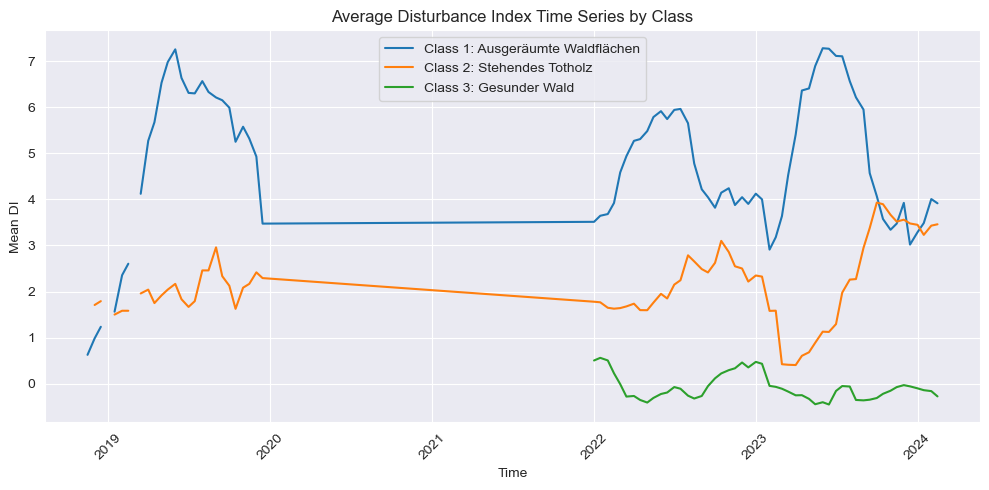

In [270]:
print(df[df['di'].notna()]['time'].sort_values().unique())
# Group by class and time, then compute mean DI and plot result
df_grouped = df.groupby(["class", "time"])["di"].mean().reset_index()

class_names = {1: "Ausgeräumte Waldflächen", 2: "Stehendes Totholz", 3: "Gesunder Wald"}

# Plot
plt.figure(figsize=(10, 5))
for class_label in df_grouped["class"].unique():
    subset = df_grouped[df_grouped["class"] == class_label]
    class_name = class_names.get(class_label, "Unknown")
    plt.plot(subset["time"], subset["di"], label=f"Class {class_label}: {class_name}")

plt.xlabel("Time")
plt.ylabel("Mean DI")
plt.title("Average Disturbance Index Time Series by Class")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Plot sample points and their di time series for each class
2023: Polygon ID 12 (Stehendes Totholz), 2 (Ausgeräumter Wald) und 16 (Gesunder Wald)

     point_id polygon_id class    FCC_Date Flight_Date  di_t+0  di_t+1  \
0           0          1     2  2023-10-01  2023-08-19     1.5     2.0   
1           1          1     2  2023-10-01  2023-08-19     1.5     2.0   
2           2          1     2  2023-09-15  2023-08-19     2.5     3.0   
3           3          1     2  2024-01-01  2023-08-19     1.0     1.0   
4           4          1     2  2023-10-01  2023-08-19     2.5     3.0   
...       ...        ...   ...         ...         ...     ...     ...   
5568     9291         27     3  2019-11-01  2022-07-18     0.0     0.0   
5569     9294         27     3  2019-11-01  2022-07-18     0.0     0.0   
5570     9295         27     3  2019-11-01  2022-07-18     0.0     0.0   
5571     9296         27     3  2019-11-01  2022-07-18     0.0     0.0   
5572     9299         27     3  2019-11-01  2022-07-18     0.0     0.0   

      di_t+10  di_t+11  di_t+12  ...  di_t-28  di_t-29  di_t-3  di_t-30  \
0         4.0      4.0      4.0  ...

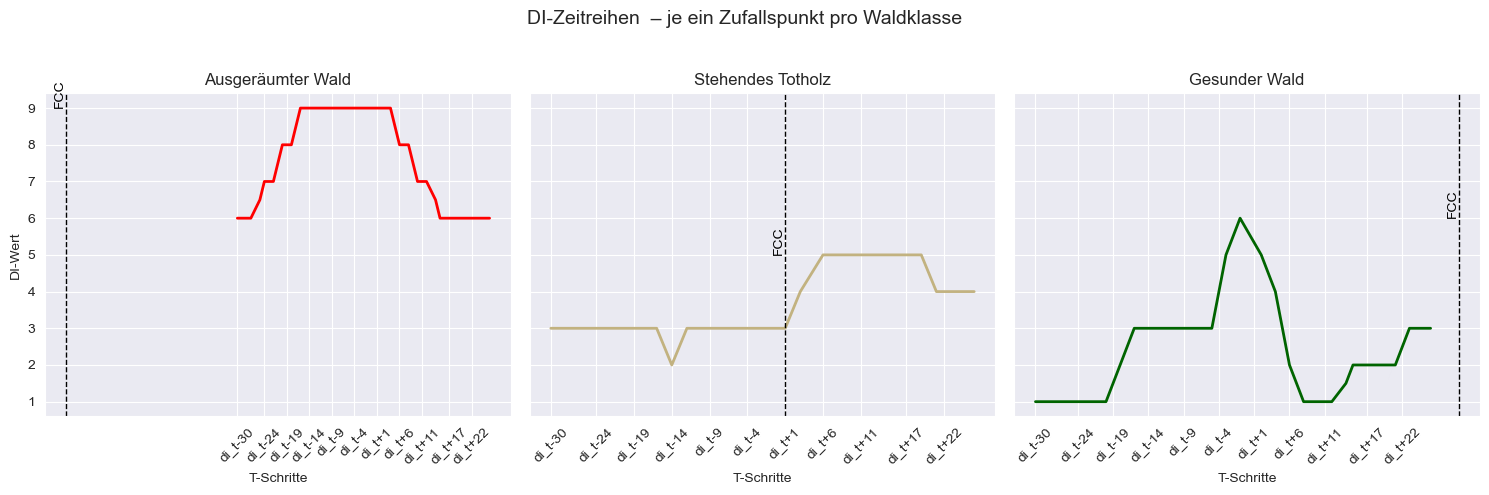

In [283]:
# CSV laden
df = gpd.read_file('Data_Collection/DI_points_timeseries/combined_time_series_wide.csv')

# Alle DI-Spalten holen & sortieren
di_cols = [col for col in df.columns if col.startswith("di_t")]
def sort_key(col):
    step = col.replace("di_t", "")
    return int(step) if step else 0
di_cols = sorted(di_cols, key=sort_key)
df[di_cols] = df[di_cols].apply(pd.to_numeric, errors="coerce")

# Interpolation (horizontal/zeitlich innerhalb eines Punkts)
df[di_cols] = df[di_cols].replace(-2147483648.0, np.nan)
df[di_cols] = df[di_cols].interpolate(method='linear', axis=1)
df[di_cols] = df[di_cols].bfill(axis=1)
df[di_cols] = df[di_cols].ffill(axis=1)

print(df)

# Ziel-Polygone mit Farben
target_polygons = {
    "2":  ("Ausgeräumter Wald", "red"),
    "12": ("Stehendes Totholz", "#c2b280"),
    "16": ("Gesunder Wald", "darkgreen")
}

# Subplots vorbereiten (3 nebeneinander)
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

for ax, (pid, (label, color)) in zip(axes, target_polygons.items()):
    subset = df[df["polygon_id"] == pid]
    if subset.empty:
        ax.set_title(f"{label} (keine Daten)")
        continue

    # Zufälligen Punkt wählen
    point = subset.sample(1).iloc[0]
    
    # Liste der relativen Wochen (als int), z.B. [-7, -6, ..., 0, ..., +6]
    rel_weeks = [int(col.replace("di_t", "")) for col in di_cols]
    
    # Werte aus Zeitreihe
    di_values = point[di_cols].values
    
    # Relativer FCC-Wochenwert
    flight_date = pd.to_datetime(point['Flight_Date'], errors='coerce')
    fcc_date = pd.to_datetime(point['FCC_Date'], errors='coerce')
    fcc_rel_week = int(((fcc_date - flight_date).days) // 7)
    
    # Wenn FCC innerhalb des vorhandenen Zeitraums liegt, zeichne Linie
    '''
    if min(rel_weeks) <= fcc_rel_week <= max(rel_weeks):
        ax.axvline(x=fcc_rel_week, color="black", linestyle="--", linewidth=1)
        ax.text(fcc_rel_week, max(di_values), "FCC", color="black", rotation=90, ha='right', va='bottom')
    '''
    
    # Plotten mit relativen Werten als X-Achse
    ax.plot(rel_weeks, di_values, color=color, linewidth=2)
    
    # Vertikale Linie bei FCC, auch wenn sie außerhalb liegt
    ax.axvline(x=fcc_rel_week, color="black", linestyle="--", linewidth=1)
    ax.text(fcc_rel_week, max(di_values), "FCC", color="black", rotation=90, ha='right', va='bottom')
    
    # X-Achse beschriften
    ax.set_xticks(rel_weeks[::5])
    ax.set_xticklabels([f"di_t{w:+}" for w in rel_weeks[::5]], rotation=45)
    ax.set_title(label)
    ax.set_xlabel("T-Schritte")

# Gemeinsame Y-Achse beschriften
axes[0].set_ylabel("DI-Wert")

# Layout
plt.suptitle("DI-Zeitreihen  – je ein Zufallspunkt pro Waldklasse", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

### Test difference of time series

In [185]:
# t-test: If data is normally distributed
from scipy.stats import ttest_ind

# Separate DI values by class
di_class1 = df[df["class"] == 2]["di"].dropna()
di_class2 = df[df["class"] == 3]["di"].dropna()
print(f"Anzahl DI-Werte für Klasse 2: {len(di_class1)}")
print(f"Anzahl DI-Werte für Klasse 3: {len(di_class2)}")


# Perform t-test
t_stat, p_value = ttest_ind(di_class1, di_class2, equal_var=False)

print(f"t-statistic = {t_stat}, p-value = {p_value}")


Anzahl DI-Werte für Klasse 2: 18854
Anzahl DI-Werte für Klasse 3: 75764
t-statistic = 193.96274182331913, p-value = 0.0


In [60]:
# Mann-Whitney U-test: If data is not normally distributed
from scipy.stats import mannwhitneyu
u_stat, p_value = mannwhitneyu(di_class1, di_class2, alternative="two-sided")
print(f"U-statistic = {u_stat}, p-value = {p_value}")

U-statistic = 1090176442.5, p-value = 0.0


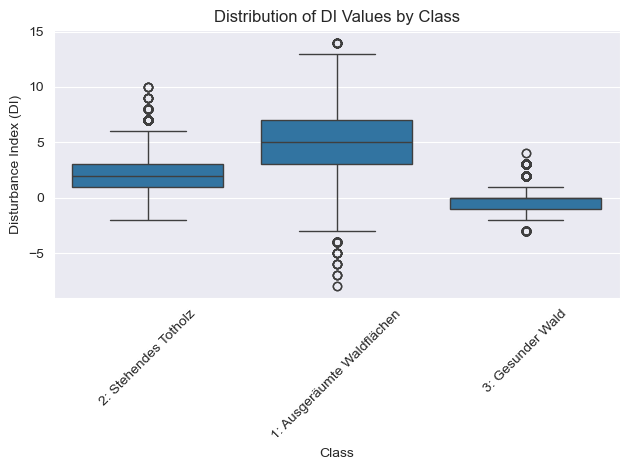

In [246]:
class_names_boxplot = {1: "1: Ausgeräumte Waldflächen", 2: "2: Stehendes Totholz", 3: "3: Gesunder Wald"}

df["class_label"] = df["class"].map(class_names_boxplot)
sns.boxplot(x="class_label", y="di", data=df)
plt.title("Distribution of DI Values by Class")
plt.xlabel("Class")
plt.ylabel("Disturbance Index (DI)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()